<a href="https://colab.research.google.com/github/shoyell/lecture_pytorch/blob/master/lecture3/exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 演習
DataLoaderの扱いに慣れていきましょう。  
DataLoaderのコードを書いて、データの読み込みとミニバッチ法の実装を行います。



## データの読み込み
以下のセルにコードを追記し、DataLoaderの設定を行いましょう。  
以下のセルの`mnist_train`と`mnist_test`に対してDataLoaderを設定します。  

In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# 訓練データを取得
mnist_train = MNIST("./data",
                    train=True, download=True,
                    transform=transforms.ToTensor())
# テストデータの取得
mnist_test = MNIST("./data",
                   train=False, download=True,
                   transform=transforms.ToTensor())
print("訓練データの数:", len(mnist_train), "テストデータの数:", len(mnist_test))

# DataLoaderの設定
img_size = 28
batch_size = 128
# ------- 以下にコードを書く -------
train_loader = DataLoader(mnist_train,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(mnist_test,
                         batch_size=batch_size,
                         shuffle=False)



# ------- ここまで -------

訓練データの数: 60000 テストデータの数: 10000


## モデルの構築

In [2]:
import torch.nn as nn
import torch.nn.functional as F

# クラス：設計図。データ（属性）と機能（メソッド）をひとまとまりにした「型」の定義
class Net(nn.Module): # 基本クラスnn.Moduleを「継承」する。PyTorchが用意した基本的なニューラルネットワークの機能に自分独自の機能を追加していく
    def __init__(self): # 初期化メソッドを呼び出す処理で、基本機能を正しく使えるようにする
        super().__init__()
        self.fc1 = nn.Linear(img_size*img_size, 1024)  # 全結合層。img_size*img_sizeはMNIST画像の総ピクセル数(28×28=784)
        self.fc2 = nn.Linear(1024, 512) # 第1隠れ層 → 第2隠れ層 (1024→512ニューロン)
        self.fc3 = nn.Linear(512, 10) #第2隠れ層 → 出力層 (512→10ニューロン)。10は数字の種類(0〜9)に対応

    def forward(self, x):
        x = x.view(-1, img_size*img_size)  # 2次元画像(バッチ×1×28×28)を平坦化
        # バッチサイズ×入力の数。結果として(バッチサイズ, 784)の形状になる
        # PyTorchのviewメソッドでは、-1を指定すると「他の次元が与えられた時に、テンソルの総要素数を保つために必要な値」を自動計算する。
        x = F.relu(self.fc1(x)) #第1隠れ層を通過後、ReLU活性化関数を適用
        x = F.relu(self.fc2(x)) #第2隠れ層を通過後、ReLU活性化関数を適用
        x = self.fc3(x) #出力層を通過（活性化関数なし）
        return x #最終的に各数字クラス(0〜9)の確率スコアを返す

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


## 学習
訓練および検証の箇所にfor文のコードを追記し、DataLoaderを使ったミニバッチ法を実装しましょう。  


In [3]:
from torch import optim
import time

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
for i in range(10):  # 10エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    # バッチごとに学習を回す
    for j, (x,t) in enumerate(train_loader):  # ← 左にfor文のコードを追記
        x, t = x.cuda(), t.cuda()  # GPU対応。各ミニバッチのデータとラベルをGPUに転送
        # xは入力画像、tは正解ラベル、jはバッチ番号（0からスタート）
        # 1周目: j=0, x=バッチ1の画像データ, t=バッチ1のラベル
        # 2周目: j=1, x=バッチ2の画像データ, t=バッチ2のラベルというような取り出し方をする
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    loss_test = 0
    for j, (x,t) in enumerate(test_loader):  # ← 左にfor文のコードを追記
        x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 2.0176639160367724 Loss_Test: 1.440936025184921
Epoch: 1 Loss_Train: 0.9221386167286302 Loss_Test: 0.6046931060809123
Epoch: 2 Loss_Train: 0.525858157733356 Loss_Test: 0.4387414477105382
Epoch: 3 Loss_Train: 0.4231802650860378 Loss_Test: 0.3753104325902613
Epoch: 4 Loss_Train: 0.37541047920550363 Loss_Test: 0.3424624314508106
Epoch: 5 Loss_Train: 0.3466618251063422 Loss_Test: 0.32099197121172013
Epoch: 6 Loss_Train: 0.3259045377469012 Loss_Test: 0.30176333918035786
Epoch: 7 Loss_Train: 0.3093646891526322 Loss_Test: 0.2894693887969361
Epoch: 8 Loss_Train: 0.29571764619111507 Loss_Test: 0.27705727859482737
Epoch: 9 Loss_Train: 0.2835428864081531 Loss_Test: 0.26706881191628645


## 誤差の推移

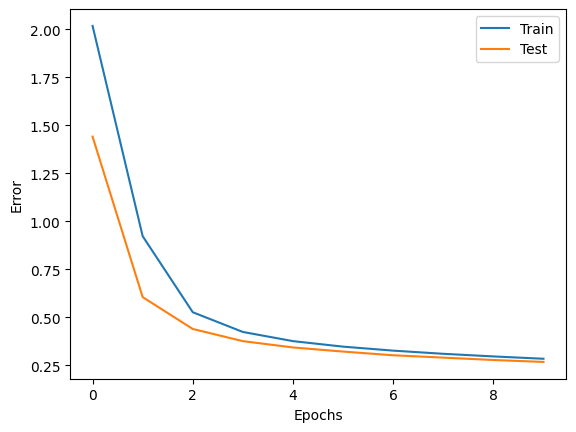

In [4]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率

In [5]:
correct = 0
total = 0
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    x = x.view(-1, img_size*img_size)
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 92.36%


# 解答例
以下は、どうしても手がかりがないときのみ参考にしましょう。

In [6]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# 訓練データを取得
mnist_train = MNIST("./data",
                    train=True, download=True,
                    transform=transforms.ToTensor())
# テストデータの取得
mnist_test = MNIST("./data",
                   train=False, download=True,
                   transform=transforms.ToTensor())
print("訓練データの数:", len(mnist_train), "テストデータの数:", len(mnist_test))

# DataLoaderの設定
img_size = 28
batch_size = 128
# ------- 以下にコードを書く -------
train_loader = DataLoader(mnist_train,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(mnist_test,
                         batch_size=batch_size,
                         shuffle=False)
# ------- ここまで -------

訓練データの数: 60000 テストデータの数: 10000


In [7]:
from torch import optim
import time

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
for i in range(10):  # 10エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ← 左にfor文のコードを追記
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    loss_test = 0
    for j, (x, t) in enumerate(test_loader):  # ← 左にfor文のコードを追記
        x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 0.2726719035014415 Loss_Test: 0.2565915921019225
Epoch: 1 Loss_Train: 0.2626531938277582 Loss_Test: 0.24902471228019346
Epoch: 2 Loss_Train: 0.25316439710382715 Loss_Test: 0.24034019715235203
Epoch: 3 Loss_Train: 0.24428474744245696 Loss_Test: 0.23224492712960212
Epoch: 4 Loss_Train: 0.23594658288048276 Loss_Test: 0.22446898943921434
Epoch: 5 Loss_Train: 0.22819489572665838 Loss_Test: 0.219093291831639
Epoch: 6 Loss_Train: 0.22068064529567893 Loss_Test: 0.2114450653684856
Epoch: 7 Loss_Train: 0.2137007964477102 Loss_Test: 0.205507851005355
Epoch: 8 Loss_Train: 0.20659554095219956 Loss_Test: 0.1999381989169913
Epoch: 9 Loss_Train: 0.20032630544672134 Loss_Test: 0.1925963196031089
